In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
from sklearn.metrics import fbeta_score
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from tqdm import tqdm

Defining project main functions

In [11]:
#Image size to use on model
width = 64
height = 64

#Data loading
def load_data(filename, dirname):
    df_train = pd.read_csv(filename)

    n = df_train.shape[0]

    x_train = np.zeros((n, width, height, 3), dtype=np.float16)
    y_train = []

    flatten = lambda l: [item for sublist in l for item in sublist]
    labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}

    i = 0
    for f, tags in tqdm(df_train.values, miniters=10):
        img = cv2.imread('{}/{}.jpg'.format(dirname, f))
        targets = np.zeros(17)
        for t in tags.split(' '):
            targets[label_map[t]] = 1 
        x_train[i] = cv2.resize(img, (width, height))
        y_train.append(targets)
        i += 1

    y_train = np.array(y_train, np.uint8)
    x_train = x_train / 256.

    return x_train, y_train

#Generate VGG based models
def model_make(input_shape, modelOption, classes):
    if(modelOption == "keras_vgg1"):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(classes, activation='softmax'))

    if(modelOption == "keras_vgg2"):
        model = Sequential()
        model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(Conv2D(256, (3, 3), activation='relu'))        
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(classes, activation='softmax'))
        
    if(modelOption == "keras_vgg3"):
        model = Sequential()
        model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(Conv2D(256, (3, 3), activation='relu'))        
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))   
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(classes, activation='softmax'))

    if(modelOption == "keras_vgg16"):
        model = Sequential()
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

        model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
        model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

        model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

        model.add(Flatten(name='flatten'))
        model.add(Dense(4096, activation='relu', name='fc1'))
        model.add(Dense(4096, activation='relu', name='fc2'))
        model.add(Dense(classes, activation='softmax', name='predictions'))
        
    if(modelOption == "keras_vgg16_dropout"):
        model = Sequential()
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
        model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))
        model.add(Dropout(0.25))

        model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))
        model.add(Dropout(0.25))

        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))
        model.add(Dropout(0.25))

        model.add(Flatten(name='flatten'))
        model.add(Dense(4096, activation='relu', name='fc1'))
        model.add(Dropout(0.5))
        model.add(Dense(4096, activation='relu', name='fc2'))
        model.add(Dropout(0.5))
        model.add(Dense(classes, activation='softmax', name='predictions'))
    
    model.compile(loss='binary_crossentropy', 
                      optimizer=Adam(lr=1e-4),
                      metrics=['accuracy'])
    print("Model: " + modelOption)
    print (model.summary())
    return model

#load model and weights
def load_model(path_weights, path_model):
    json_file = open(path_model, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(path_weights)
    print("Loaded model from disk")
    return model


def generate_label(y):
    labels = []
    idx = np.argsort(y)
    for i in range(-1, -18, -1):
        j = idx[i]
        if y[j] > 0.2:
            labels.append(inv_label_map[j])
    return ' '.join(labels)

Data Analysis

There is 17 unique labels including set(['slash_burn', 'clear', 'blooming', 'primary', 'cloudy', 'conventional_mine', 'water', 'haze', 'cultivation', 'partly_cloudy', 'artisinal_mine', 'habitation', 'bare_ground', 'blow_down', 'agriculture', 'road', 'selective_logging'])
primary              37513
clear                28431
agriculture          12315
road                  8071
water                 7411
partly_cloudy         7261
cultivation           4547
habitation            3660
haze                  2697
cloudy                2089
bare_ground            862
selective_logging      340
artisinal_mine         339
blooming               332
slash_burn             209
blow_down              101
conventional_mine      100
dtype: int64


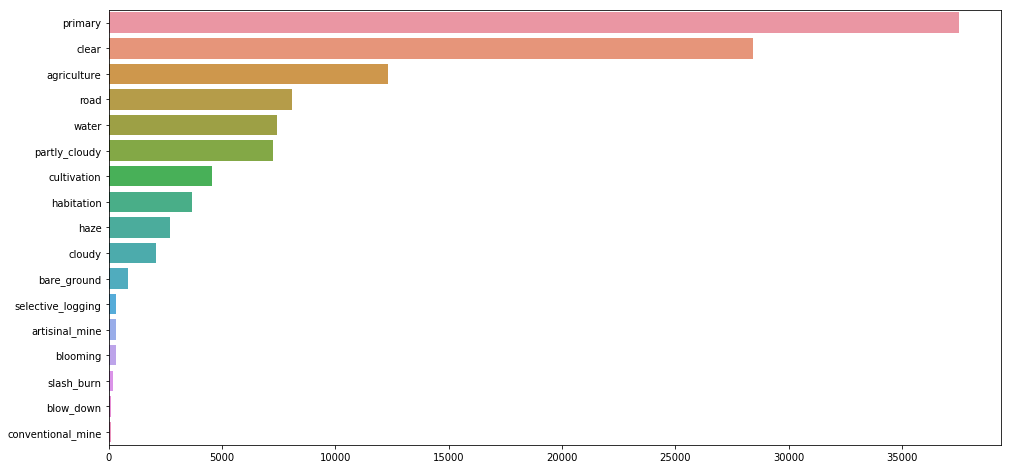

In [5]:
df_train = pd.read_csv('train_v2.csv')

#Printing labels from data
labels_list = list(chain.from_iterable([tags.split(" ") for tags in df_train['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

#Printing data label histogram
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
print(labels_s)
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')
plt.show()

In [4]:
#Data loading
x, y = load_data('train_v2.csv', '/train-jpg')
print(x.shape)

imgCount, width, height, rgb = x.shape
# 80% train / 20% testmonitor
split = int(imgCount*0.8); 
x_train, x_valid, y_train, y_valid = x[:split], x[split:], y[:split], y[split:]

Running the model

In [13]:
model_list = ["keras_vgg1"]
input_shape = (width, height, 3)
classes = 17

for model_name in model_list:
    model_experiment = model_make(input_shape, model_name, classes)
    callbacks = [History, 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath='weights/'+ model_name + '.hdf5', verbose=1, save_best_only=True, 
                             save_weights_only=True, mode='auto')]
    history = model_experiment.fit(x_train, y_train,
          batch_size=128,
          epochs=50,
          verbose=1,
          validation_data=(x_valid, y_valid))
    p_valid = model_experiment.predict(x_valid, batch_size=128)
    #Printing Beta score for model
    print(fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))
    
    #Saving model for later use
    model_save_weights = model_name + '.h5'
    model_save_json = model_name + ".json"
    model_experiment.save_weights(model_save_weights)
    model_json = model_experiment.to_json()
    with open(model_save_json, "w") as json_file:
        json_file.write(model_json)
    
    #Printing model results (acc and loss per epoch)
    plt.figure(figsize=(20,20))
    plt.subplots_adjust(hspace=0.4,wspace=0.4)
    plt.subplot(221)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.subplot(222)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Model: keras_vgg1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 64)        0  

NameError: name 'x_valid' is not defined

Result CSV Generation

In [18]:
x_test, y_test = load_data('sample_submission_v2.csv', 'test-jpg')
model = load_model("keras_vgg16.h5", "keras_vgg16.json")

print("Start making predictions based on model")
y = model.predict(x_test, batch_size=100, verbose=1)

df = pd.read_csv('sample_submission_v2.csv')

df_train = pd.read_csv('inputs/train_v2.csv')
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

generate_label(y[0])
df.tags = map(generate_label, y) 
print("Writing csv for submission")
df.to_csv('submission.csv', columns=['image_name', 'tags'], index=False)

TypeError: 'str' object is not callable